In [1]:
import ast
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(1234)
from itertools import combinations

import prince 
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import Normalizer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

from pyclustering.cluster.clarans import clarans
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.silhouette import silhouette_ksearch_type, silhouette_ksearch
from pyclustering.utils import read_sample
from pyclustering.cluster import cluster_visualizer_multidim

In [2]:
dat = pd.read_csv('F:/capstone_listenfirst/brands_with_extras_kmodes.csv')

In [3]:
dat.columns

Index(['brand_ods_id', 'replace', 'released_on', 'ticker_symbol', 'genres',
       'data_profile_dcs_uid', 'data_profile_channel_type',
       'data_profile_source_type', 'data_affiliation_active_flag',
       'data_affiliation_start_date_key', 'data_affiliation_end_date_key',
       'genre_list', 'top_genre', 'released_year', 'year_bin', 'budget',
       'production_company', 'rating', 'source', 'franchise', 'genre_grouped',
       'inflated_budget', 'budget_cat', 'year_q_bin', 'rank',
       'production_company_bin'],
      dtype='object')

# Multiple Correspondence Analysis to KMeans

## Fit MCA

In [406]:
dat['year_q_bin'] = dat['year_q_bin'].astype(str)
dat['genre_list'] = [ast.literal_eval(str(x)) for x in dat['genre_list']]

genre_set = set()
for row in dat['genre_list']:
    for g in row:
        genre_set.add(g)
dat['released_year'] = pd.to_datetime(dat['released_year'], format='%Y').dt.year.astype(int)

dat_filt = dat[dat['released_year']>=2010].drop_duplicates('replace').loc[:, ['replace', 'genre_list', 'top_genre', 'year_q_bin', 'budget_cat',
                                                                        'production_company_bin', 'rating', 'source', 'franchise', 'genre_grouped']]
prince_features = dat_filt

glist_mlb = MultiLabelBinarizer()
ggroup_ohe = OneHotEncoder()
ybin_ohe = OneHotEncoder()
bcat_ohe = OneHotEncoder()
rating_ohe = OneHotEncoder()
src_ohe = OneHotEncoder()

glist = pd.DataFrame(glist_mlb.fit_transform(prince_features['genre_list']).tolist())
genregroup = pd.DataFrame(ggroup_ohe.fit_transform(prince_features['genre_grouped'].values.reshape(-1, 1)).toarray().tolist())
ybin = pd.DataFrame(ybin_ohe.fit_transform(prince_features['year_q_bin'].astype(str).values.reshape(-1, 1)).toarray().tolist())
bcat = pd.DataFrame(bcat_ohe.fit_transform(prince_features['budget_cat'].values.reshape(-1, 1)).toarray().tolist())
rating = pd.DataFrame(rating_ohe.fit_transform(prince_features['rating'].values.reshape(-1, 1)).toarray().tolist())
src = pd.DataFrame(src_ohe.fit_transform(prince_features['source'].values.reshape(-1, 1)).toarray().tolist())

prince_ohe = pd.concat([prince_features.loc[:, 'replace'], glist, genregroup,
                        ybin, bcat, rating, src], axis=1)

prince_no_ohe = prince_features.iloc[:, 1:]

In [407]:
pickle.dump(glist_mlb, open('glist_mlb.pkl', 'wb'))
pickle.dump(ggroup_ohe, open('ggroup_ohe.pkl', 'wb'))
pickle.dump(ybin_ohe, open('ybin_ohe.pkl', 'wb'))
pickle.dump(bcat_ohe, open('bcat_ohe.pkl', 'wb'))
pickle.dump(rating_ohe, open('rating_ohe.pkl', 'wb'))
pickle.dump(src_ohe, open('src_ohe.pkl', 'wb'))

In [408]:
prince_ohe

,replace,0,1,2,3,4,5,6,7,8,...,0,1,2,0,1,2,3,0,1,2
0,Blade Runner 2049,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,Geostorm,1,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,Ready Player One,1,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,Fury,1,0,0,0,0,0,0,0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,Nightcrawler,0,0,0,0,0,0,1,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,To All the Boys: P.S. I Still Love You,0,0,0,0,0,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
526,Chef,0,0,0,0,0,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
527,A Street Cat Named Bob,0,0,0,0,0,1,0,0,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
528,Behind the Candelabra,0,0,0,0,1,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [409]:
mca = prince.MCA()

mca = mca.fit(prince_ohe.iloc[:, 1:])
res = mca.transform(prince_ohe.iloc[:, 1:])
res

,0,1
0,0.325748,-0.817746
1,0.268105,-0.742653
2,0.207836,-0.829028
3,-0.283408,-0.034750
4,-0.924838,-0.377839
...,...,...
525,-0.511125,0.669818
526,-0.196507,0.137547
527,0.046148,0.265358
528,-0.784380,1.259520


## Fit Kmeans on results with ohe

##### Find optimal clusters using silhouette

In [303]:
for n_clusters in list(range(2, 11)):
    km = KMeans(n_clusters=n_clusters, n_init=1000)
    preds = km.fit_predict(res)
    
    print('Silhouette score for {} clusters is {}'.format(n_clusters, silhouette_score(res, preds)))

Silhouette score for 2 clusters is 0.4286601560585792
Silhouette score for 3 clusters is 0.49056413576754493
Silhouette score for 4 clusters is 0.5102565872503908
Silhouette score for 5 clusters is 0.5008640484131194
Silhouette score for 6 clusters is 0.4569264298048357
Silhouette score for 7 clusters is 0.44322918080432194
Silhouette score for 8 clusters is 0.4599250467639537
Silhouette score for 9 clusters is 0.431639650637295
Silhouette score for 10 clusters is 0.4278834860510571


##### Find optimal clusters using elbow plot

In [304]:
dist = []
for x in list(range(2, 11)):
    km = KMeans(n_clusters=x, n_init=1000)
    km.fit(res)
    dist.append(km.inertia_)

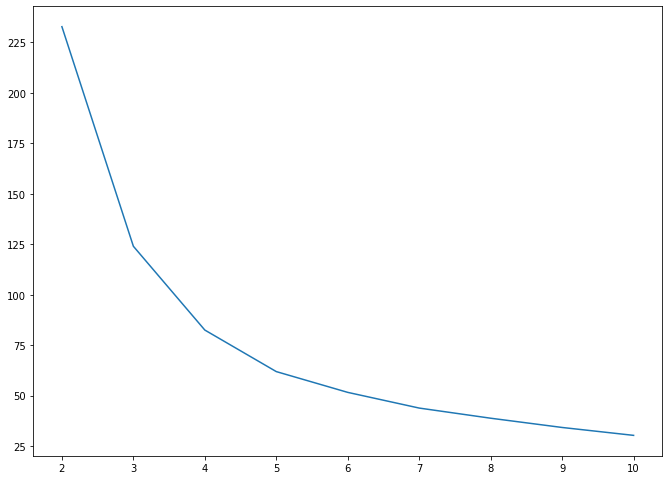

In [305]:
plt.figure(figsize=(11.27, 8.27))
plt.plot(list(range(2, 11)), dist)
plt.xticks(list(range(2, 11)))
plt.show()

## Fit KMeans with optimal clusters

In [410]:
km3 = KMeans(n_clusters=3, n_init=10000)
preds_optimal_3 = km3.fit_predict(res)

In [411]:
dat['clusters_3'] = preds_optimal_3

In [412]:
km4 = KMeans(n_clusters=4, n_init=10000)
preds_optimal_4 = km4.fit_predict(res)

In [413]:
dat['clusters_4'] = preds_optimal_4

In [414]:
km5 = KMeans(n_clusters=5, n_init=10000)
preds_optimal_5 = km5.fit_predict(res)

## Save K-Means clusters

In [416]:
dat.to_csv('alex_clusters.csv')

In [417]:
pickle.dump(mca, open('mca.pkl', 'wb'))
pickle.dump(km3, open('kmeans3.pkl', 'wb'))
pickle.dump(km4, open('kmeans4.pkl', 'wb'))
pickle.dump(km5, open('kmeans5.pkl', 'wb'))

## Test prediction using loaded models

In [4]:
predict = dat[(dat['released_year']>=2010)&(dat['replace']=='Looper')]\
            .drop_duplicates('replace').loc[:, ['genre_list', 'genre_grouped', 'year_q_bin', 'budget_cat', 
                                                'rating', 'source']]

In [5]:
glist_mlb = pickle.load(open('glist_mlb.pkl', 'rb'))
ggroup_ohe = pickle.load(open('ggroup_ohe.pkl', 'rb'))
ybin_ohe = pickle.load(open('ybin_ohe.pkl', 'rb'))
bcat_ohe = pickle.load(open('bcat_ohe.pkl', 'rb'))
rating_ohe = pickle.load(open('rating_ohe.pkl', 'rb'))
src_ohe = pickle.load(open('src_ohe.pkl', 'rb'))

In [6]:
predict_features = pd.concat([pd.DataFrame(glist_mlb.transform(predict['genre_list']).tolist()),
                              pd.DataFrame(ggroup_ohe.transform(predict['genre_grouped'].values.reshape(-1, 1)).toarray().tolist()),
                              pd.DataFrame(ybin_ohe.transform(predict['year_q_bin'].astype(str).values.reshape(-1, 1)).toarray().tolist()),
                              pd.DataFrame(bcat_ohe.transform(predict['budget_cat'].values.reshape(-1, 1)).toarray().tolist()),
                              pd.DataFrame(rating_ohe.transform(predict['rating'].values.reshape(-1, 1)).toarray().tolist()),
                              pd.DataFrame(src_ohe.transform(predict['source'].values.reshape(-1, 1)).toarray().tolist())], axis=1)

c:\users\alex\appdata\local\programs\python\python38\lib\site-packages\sklearn\preprocessing\_label.py:986: UserWarning: unknown class(es) [' ', "'", ',', 'A', 'C', 'F', 'S', 'T', '[', ']', 'c', 'e', 'h', 'i', 'l', 'm', 'n', 'o', 'r', 't'] will be ignored
  warnings.warn('unknown class(es) {0} will be ignored'


In [379]:
mca = pickle.load(open('mca.pkl', 'rb'))
predict_test = mca.transform(predict_features)

In [400]:
km = pickle.load(open('kmeans3.pkl', 'rb'))
km.predict(predict_test)

array([1])

# K-Modes

In [60]:
filt = dat.drop_duplicates(['replace'])
encoded = filt.loc[:, ['genre_grouped', 'year_q_bin', 'budget_cat',
                       'production_company_bin', 'rating', 'franchise']]
le_genre = LabelEncoder()
le_year = LabelEncoder()
le_budget = LabelEncoder()
le_production = LabelEncoder()
le_rating = LabelEncoder()
le_source = LabelEncoder()
le_franchise = LabelEncoder()

encoded['genre_le'] = le_genre.fit_transform(encoded['genre_grouped'])
encoded['year_le'] = le_year.fit_transform(encoded['year_q_bin'])
encoded['budget_le'] = le_budget.fit_transform(encoded['budget_cat'])
encoded['production_le'] = le_production.fit_transform(encoded['production_company_bin'])
encoded['rating_le'] = le_rating.fit_transform(encoded['rating'])
# encoded['source_le'] = le_source.fit_transform(encoded['source'])
encoded['franchise_le'] = le_franchise.fit_transform(encoded['franchise'])

feat = encoded.loc[:, ['genre_le', 'year_le', 'budget_le', 'production_le', 
                       'rating_le', 'franchise_le']]

# KModes

In [61]:
km = KModes(n_clusters=5, init='Cao', verbose=1, n_init=1)
clusters = km.fit_predict(feat)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 57, cost: 1387.0


In [63]:
cost = []
for clust in range(2, 21):
    km = KModes(n_clusters=clust, init='Huang', verbose=0)
    km.fit_predict(feat)
    cost.append(km.cost_)

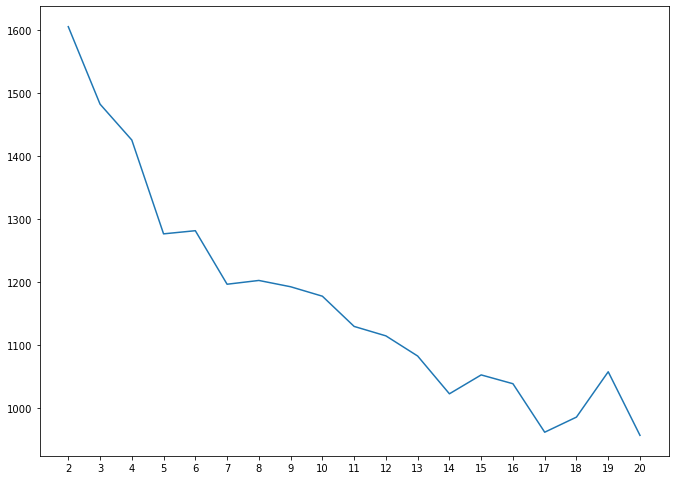

In [64]:
plt.figure(figsize=(11.27, 8.27))
plt.plot(list(range(2, 21)), cost)
plt.xticks(list(range(2, 21)))
plt.show()

In [65]:
cost = []
for clust in range(2, 21):
    km = KModes(n_clusters=clust, init='Cao', verbose=0)
    km.fit_predict(feat)
    cost.append(km.cost_)

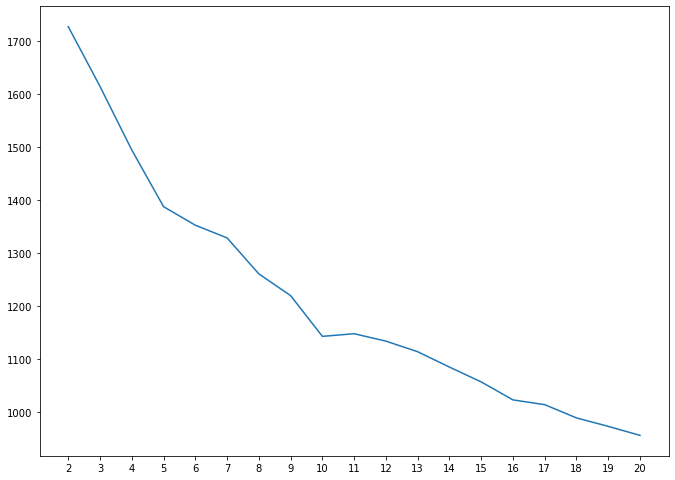

In [66]:
plt.figure(figsize=(11.27, 8.27))
plt.plot(list(range(2, 21)), cost)
plt.xticks(list(range(2, 21)))
plt.show()

In [105]:
km.

array([[4, 6, 2, 2, 2, 0],
       [0, 0, 0, 0, 3, 1],
       [2, 5, 0, 1, 1, 0],
       [8, 5, 2, 0, 3, 0],
       [1, 3, 0, 0, 2, 1]], dtype=int64)

In [67]:
km = KModes(n_clusters=5, init='Cao', verbose=1, n_init=1)
clusters = km.fit_predict(feat)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 57, cost: 1387.0


In [69]:
dat.loc[:, 'cluster'] = clusters

# CLARANS

In [76]:
enc_list = np.array(feat.values).tolist()

In [109]:
clar = clarans(enc_list, 8, 50, 10)
clar.process()

In [112]:
centers = filt.iloc[clar.get_medoids(), :]
centers.to_csv('alex_CLARANS_centers.csv')

## Search for optimal number of clusters

In [77]:
search_instace = silhouette_ksearch(enc_list, 5, 20, 
                                    algorithm=silhouette_ksearch_type.KMEDOIDS).process()
amt = search_instace.get_amount()
amt

6

In [79]:
clar = clarans(enc_list, amt, 30, 8)
clar.process()

In [82]:
for x in list(enumerate(clar.get_clusters())):
    for ind in x[1]:
        dat.at[ind, 'clarans_cluster'] = int(x[0])

In [104]:
dat[dat['clarans_cluster']==5].loc[:, ['replace'] + list(encoded.columns)]

,replace,genre_grouped,year_q_bin,budget_cat,production_company_bin,rating,franchise,genre_le,year_le,budget_le,production_le,rating_le,franchise_le
0,Blade Runner 2049,Fantasy,5,HighBudget,Top5,R,Yes,NaN,NaN,NaN,NaN,NaN,NaN
4,Nightcrawler,Thriller,2,MediumBudget,Top100+,R,No,NaN,NaN,NaN,NaN,NaN,NaN
5,Crimson Peak,Horror,3,HighBudget,Top5,R,No,NaN,NaN,NaN,NaN,NaN,NaN
10,Lone Survivor,Thriller,1,MediumBudget,Top5,R,No,NaN,NaN,NaN,NaN,NaN,NaN
11,The Expendables 3,Thriller,2,HighBudget,Top100,PG-13,Yes,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,Annabelle,Horror,2,MediumBudget,Top5,R,Yes,NaN,NaN,NaN,NaN,NaN,NaN
540,Black Swan*,Thriller,1,MediumBudget,Top100,R,No,NaN,NaN,NaN,NaN,NaN,NaN
546,Fight Club*,Thriller,1,HighBudget,Top100,R,No,NaN,NaN,NaN,NaN,NaN,NaN
561,Looper,Thriller,1,MediumBudget,Top100+,R,No,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
pd.DataFrame(clar.get_medoids()).to_csv('alex_CLARANS_centers.csv')
pd.DataFrame(clar.get_clusters()).to_csv('alex_CLARANS_clusters.csv')

## Load clusters and centers to observe their accuracy

In [9]:
clust = pd.read_csv('alex_CLARANS_clusters.csv')

In [10]:
clust

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,184,185,186,187,188,189,190,191,192,193
0,0,41,138,157,175,184,220,256,268,300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,2,8,10,11,20,32,38,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,12,15,16,22,33,34,36,45,47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,3,6,7,9,14,17,18,23,...,529.0,536.0,539.0,545.0,547.0,548.0,549.0,557.0,559.0,560.0
4,4,5,24,27,30,44,52,59,100,102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,4,13,19,21,26,73,75,76,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# K Prototypes

In [35]:
filt = filt.loc[:, ['top_genre', 'released_year', 'year_bin']].apply(le.fit_transform)
filt['budget'] = np.random.randint(25000000, 200000000, len(encoded))

In [36]:
filt

,top_genre,released_year,year_bin,budget
0,17,25,1,98515479
1,0,25,1,185414902
2,17,26,2,34318141
3,0,22,0,170631312
4,6,22,0,112390221
...,...,...,...,...
4885,19,1,0,84402985
4995,12,22,0,196885128
5214,8,27,3,189499451
5257,3,26,2,72911890


In [40]:
kp = KPrototypes(n_clusters=15, init='Huang', verbose=0)
kp.fit(filt, categorical=[0, 1, 2])

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 124, ncost: 1.0275216735092614e+16
Run: 1, iteration: 2/100, moves: 76, ncost: 8605599147000341.0
Run: 1, iteration: 3/100, moves: 50, ncost: 7601475801770450.0
Run: 1, iteration: 4/100, moves: 23, ncost: 7404214816177688.0
Run: 1, iteration: 5/100, moves: 22, ncost: 7213943005950467.0
Run: 1, iteration: 6/100, moves: 15, ncost: 7138225860229366.0
Run: 1, iteration: 7/100, moves: 12, ncost: 7066750893197116.0
Run: 1, iteration: 8/100, moves: 12, ncost: 6965474461287827.0
Run: 1, iteration: 9/100, moves: 4, ncost: 6945720988144550.0
Run: 1, iteration: 10/100, moves: 5, ncost: 6929182483217878.0
Run: 1, iteration: 11/100, moves: 1, ncost: 6928165191256704.0
Run: 1, iteration: 12/100, moves: 0, ncost: 6928165191256704.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 71, ncost: 1.2670270361827416e+16
Run: 2, itera

Run: 9, iteration: 11/100, moves: 12, ncost: 1.0464359786016014e+16
Run: 9, iteration: 12/100, moves: 15, ncost: 1.0219875874607108e+16
Run: 9, iteration: 13/100, moves: 20, ncost: 9804866236313898.0
Run: 9, iteration: 14/100, moves: 20, ncost: 9475131296874378.0
Run: 9, iteration: 15/100, moves: 17, ncost: 9259469520517980.0
Run: 9, iteration: 16/100, moves: 8, ncost: 9206138142952126.0
Run: 9, iteration: 17/100, moves: 8, ncost: 9151773036092702.0
Run: 9, iteration: 18/100, moves: 7, ncost: 9096366690698088.0
Run: 9, iteration: 19/100, moves: 9, ncost: 9038443073622628.0
Run: 9, iteration: 20/100, moves: 6, ncost: 8997130047591259.0
Run: 9, iteration: 21/100, moves: 14, ncost: 8840290401455052.0
Run: 9, iteration: 22/100, moves: 8, ncost: 8796901220651891.0
Run: 9, iteration: 23/100, moves: 4, ncost: 8765150303651249.0
Run: 9, iteration: 24/100, moves: 9, ncost: 8704276411835249.0
Run: 9, iteration: 25/100, moves: 12, ncost: 8594988954081144.0
Run: 9, iteration: 26/100, moves: 8, nco

KPrototypes(cat_dissim=<function matching_dissim at 0x00000114597A8670>,
            gamma=24725506.791886486, init='Huang', max_iter=100, n_clusters=15,
            n_init=10, n_jobs=1,
            num_dissim=<function euclidean_dissim at 0x00000114597A88B0>,
            random_state=None, verbose=1)

In [43]:
preds = kp.predict(filt, categorical=[0, 1, 2])

In [48]:
cost_kp = []
for clust in range(5, 21):
    km = KPrototypes(n_clusters=clust, init='Cao', verbose=0)
    km.fit_predict(filt, categorical=[0, 1, 2])
    cost_kp.append(km.cost_)

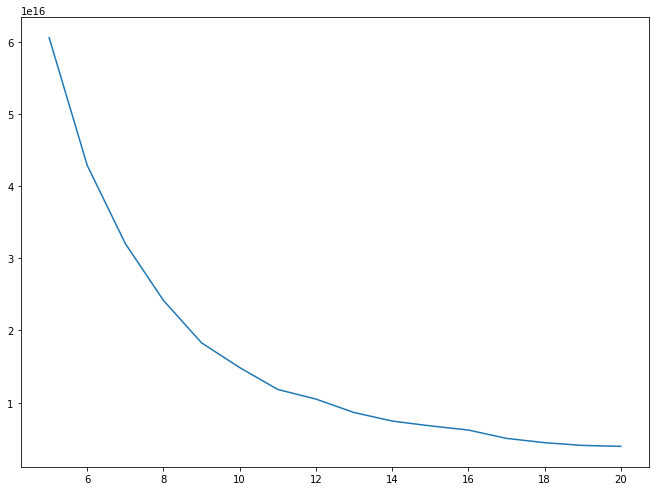

In [49]:
plt.figure(figsize=(11.27, 8.27))
plt.plot(list(range(5, 21)), cost_kp)

In [50]:
cost_kp = []
for clust in range(5, 21):
    km = KPrototypes(n_clusters=clust, init='Huang', verbose=0)
    km.fit_predict(filt, categorical=[0, 1, 2])
    cost_kp.append(km.cost_)

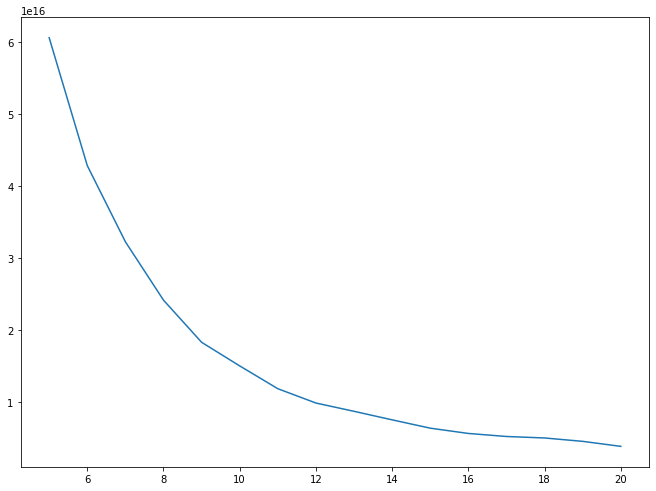

In [51]:
plt.figure(figsize=(11.27, 8.27))
plt.plot(list(range(5, 21)), cost_kp)